# Полносвязанные нейронные сети
В предыдущем домашнем задании вы реализовали полносвязанную двухслойную нейронную сеть. Реализация была простой, но не модульной, поскольку потери и градиент вычислялись в одной монолитной функции. Это допустимо для простой двухслойной сети, но непрактично, если необходимо реализовать более крупные сети. В идеале мы хотим создавать сети с использованием  модульного подхода, чтобы мы могли изолировать отдельные типы слоев, а затем объединить их в модели с разными архитектурами.

В этом задании необходимо реализовать полносвязанные сети, используя  модульный подход. Для каждого слоя мы реализуем функции прямого `forward` и обратного `backward` распространения. Функция `forward` будет принимать входные даные, веса и другие параметры и будет возвращать как выходные значения, так и кэшированные значения, сохраняющие данные, необходимые для выполнения обратного распространения, например:

```python
def layer_forward(x, w):
  """ Принимает на вход x и веса w """
  # Некоторые вычисления ...
  z = # ... внутренние значения
  # Дополнительные вычисления ...
  out = # выход
   
  cache = (x, w, z, out) # Значения, которые нужны для вычисления градиентов
    
  return out, cache
```

Функция обратного распостранения будет получать производные восходящего потока и объект `cache` и будет возвращать градиенты по отношению к входам и весам, например:

```python
def layer_backward(dout, cache):
  """
  Принимает dout (производная функции потерь по выходу) и кеш,
  и вычисляет производные по отношению ко входам.
  """
  # Извлечение значений из кэша
  x, w, z, out = cache
  
  # Используем значения из кэша для вычисления производных
  dx = # Производная потерь по x
  dw = # Производная потерь по w
  
  return dx, dw
```
После реализации слоев расмотреным способом мы сможем легко объединить их для создания классификаторов с разными архитектурами.

В дополнение к реализации полносвязанных сетей произвольной глубины мы также изучим различные правила обновления (для оптимизации) и также введем Dropout в качестве регуляризатора, а  нормализацию на блоке/ слое в качестве инструмента для более эффективной оптимизации глубоких сетей.  

In [7]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Афинный слой: прямое распространение
Откройте файл `cs231n/layers.py` и реализуйте функцию `affine_forward`.


Когда Вы реализуете эту функцию, Вы можете протестировать  реализацию, выполнив следующие действия:

In [9]:
# Тестирование функции affine_forward

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Сравните выход вашей функции с требуемым. Ошибка должна быть около e-9
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.7698500479884e-10


# Аффинный слой: обратное распространение
Теперь реализуем функцию `affine_backward` и протестируем реализацию, выполнив сопоставление с численным градиентом.

In [10]:
# Тест функции affine_backward 
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# Ошибка должна быть примерно на уровне e-10 или меньше
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


# Активационная функция ReLU: прямой  путь
Реализуйт прямой проход для  ReLU нелинейности в виде функции `relu_forward` и протестируйте реализацию, используя код:

In [11]:
# Тест функции relu_forward

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Сравните выход функции с требуемым. Ошибка должна быть порядка e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# Активационная функция ReLU: обратный путь
Теперь реализуем обратный проход для  ReLU нелинейности в виде функции `relu_backward` и проверим  реализацию с помощью  численного градиента:

In [12]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# Ошибка должна быть порядка e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Вопрос 1: 
Мы просили Вас реализовать ReLU, но есть множество других функций активации, которые можно использовать в нейронных сетях, каждая из которых имеет свои плюсы и минусы. В частности, проблема, обычно встречающаяся с активационными функциями, - это получение нулевого (или близкого к нулю) градиентного потока во время обратного распространения. Для какой из следующих функций активации характерна эта проблема? Если мы рассматриваем эти функции как одномерные, то какие входные значения приведут к такому поведению?
1. Сигмоид
2. ReLU
3. Утечка ReLU

## Ответ:
ReLU. В нуле.

# "Сэндвич" слои
Существуют некоторые общие шаблоны слоев, которые часто используются в нейронных сетях. Например, аффинные слои часто сопровождаются нелинейностью ReLU. Чтобы упростить решение 
задач, мы определили несколько удобных слоев в файле `cs231n / layer_utils.py`.

Просмотрите функции `affine_relu_forward` и` affine_relu_backward` и запустите проверку численного  градиента, чтобы проверить обратное распространение:

In [13]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Относительная погрешность должна быть примерно на уровне e-10 или меньше
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.395535042049294e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Слои функций потерь: Softmax и SVM
Вы реализовали эти функции потерь в предыдущих заданиях, поэтому здесь  мы просто предоставим готовый код этих для этих функций. Вы все равно должны убедиться, что понимаете, как они работают, просмотрев реализации в cs231n / layers.py.

Вы должны убедиться, что реализации верны, выполнив следующие действия:

In [14]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Тест функции svm_loss. Значение потерь должны быть около 9, ошибка dx - порядка e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Тест функции softmax_loss.Значение потерь должно быть близко 2.3, ошибка dx - порядка e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Двухслойная сеть
В предыдущем задании вы реализовали двухслойную нейронную сеть в одном монолитном классе. Теперь, когда Вы реализовали модульные версии необходимых слоев, необходимо переопределить двухслойную сеть, используя модульную реализацию.

Откройте файл `cs231n/classifiers/fc_net.py` и завершите реализацию класса `TwoLayerNet`. Этот класс будет служить моделью для других сетей, которые вы реализуете в этом задании.  Запустите ячейку ниже, чтобы протестировать вашу реализацию.

In [16]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Ошибки должны быть около e-7 или менее
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.17e-10
b1 relative error: 6.19e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Решатель
В предыдущем задании операторы обучения моделей были включены непосредственно в саму модель. Следуя модульному подходу, в этом задания мы выделим операторы обучения моделей в отдельный класс.

Откройте файл `cs231n / solver.py` и прочитайте его, чтобы ознакомиться с API. После этого используйте экземпляр объекта `Solver` для обучения объекта 2-х слойной сети `TwoLayerNet`, которая достигает  точности не менее 50% на валидационном множестве.

In [17]:
##############################################################################
# ЗАДАНИЕ: используйте экземпляр Solver для обучения TwoLayerNet,            #
# которая достигает как минимум  50% точности на мно-ве валидации.           #
##############################################################################
model = TwoLayerNet(hidden_dim = 200,reg = 0.5)
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=2, batch_size=250,
                print_every=100)
solver.train()
##############################################################################
#                             КОНЕЦ ВАШЕГО КОДА                              #
##############################################################################

(Iteration 1 / 392) loss: 2.460943
(Epoch 0 / 2) train acc: 0.158000; val_acc: 0.152000
(Iteration 101 / 392) loss: 1.904372
(Epoch 1 / 2) train acc: 0.440000; val_acc: 0.438000
(Iteration 201 / 392) loss: 1.805063
(Iteration 301 / 392) loss: 1.701123
(Epoch 2 / 2) train acc: 0.458000; val_acc: 0.467000


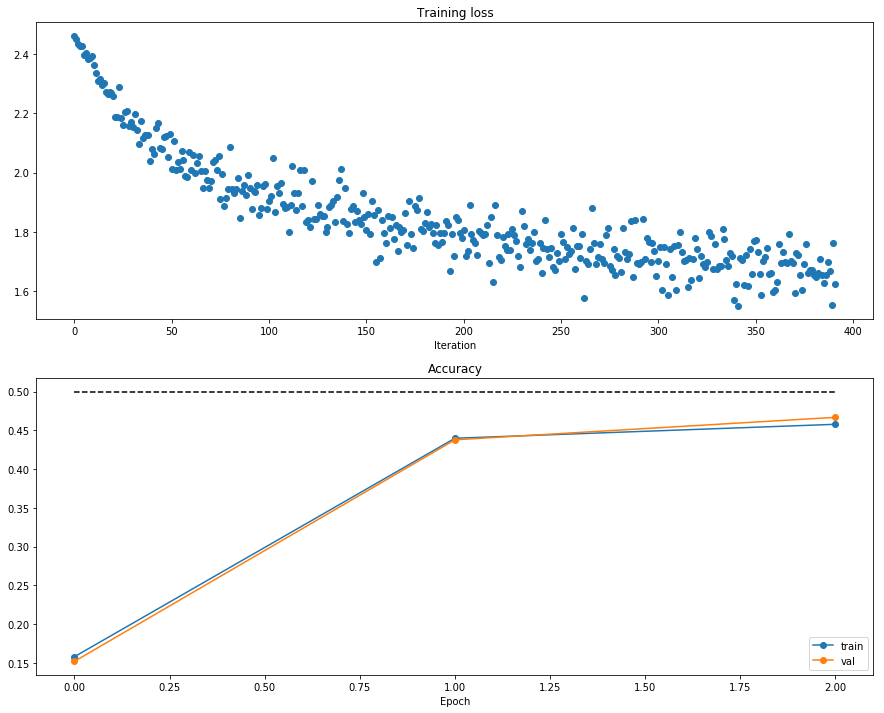

In [18]:
# Выполните эту ячейку, чтобы визуализировать потери обучения и точности

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Многослойная сеть
Теперь реализуем полносвязанную сеть с произвольным количеством скрытых слоев.

Просмотрите класс `FullyConnectedNet` в файле `cs231n/classifiers/fc_net.py`.

Реализуйте инициализацию, прямой и обратный пути. На данный момент не беспокойтесь о реализации dropout или нормализации на блоке/слое; мы добавим эти функции позже. 


## Начальные потери и проверка градиента #

В качестве проверки на работоспособности оцените начальные потери и значения градиентов как с регуляризацией, так и без нее. Выглядят ли первоначальные потери обоснованными?

В ходе проверки градиента вы должны ожидать ошибки около 1е-7 или меньше.

In [23]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Большинство ошибок должно быть порядка e-7 или меньше.
  # ПРИМЕЧАНИЕ: Допустима, однако,  ошибка для W2 порядка e-5
  # при reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.14e-08
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


В качестве другой проверки работоспособности убедитесь, что вы можете получить переобучение на небольшом наборе данных из 50 изображений. Сначала мы испытаем трехслойную сеть со 100 нейронами в каждом скрытом слое. В следующей ячейке подберите скорость обучения и масштаб инициализирующих значений для достижения 100% точности в ходе обучения на 20 эпохах.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

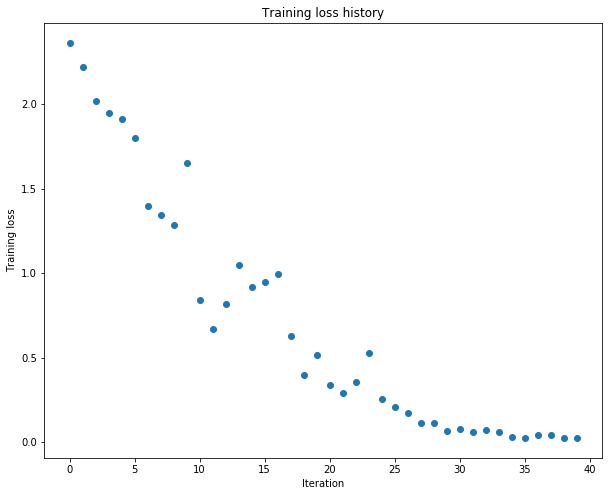

In [24]:
# ЗАДАНИЕ: используйте трехслойную сеть, чтобы достичь переобучения на
# 50 обучающих примерах при соответствующем выборе
# скорости обучения и масштаба инициализации.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Теперь попробуйте использовать пятислойную сеть со 100 нейронами на каждом слое, чтобы получить переобучение на 50 обучающих примерах. Вам снова придется корректировать скорость обучения и инициализацию весов, при этом вы должны достичь 100% точности обучения в течение 20 эпох.

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.119000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.292986
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.290870
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 

(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 21 / 40) loss: 2.300808
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 31 / 40) loss: 2.298186
(Epoch 16 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 17 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 18 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 19 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 20 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.100000; val_acc: 0.107000
(Epoch 3 / 20) train 

(Epoch 17 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 18 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 19 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 20 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.112000
(Iteration 11 / 40) loss: 2.302540
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302491
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc:

(Epoch 5 / 20) train acc: 0.120000; val_acc: 0.105000
(Iteration 11 / 40) loss: 2.302549
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 8 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 9 / 20) train acc: 0.120000; val_acc: 0.105000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302348
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 2.302473
(Epoch 16 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 17 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 18 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 19 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 20 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 1 / 40) l

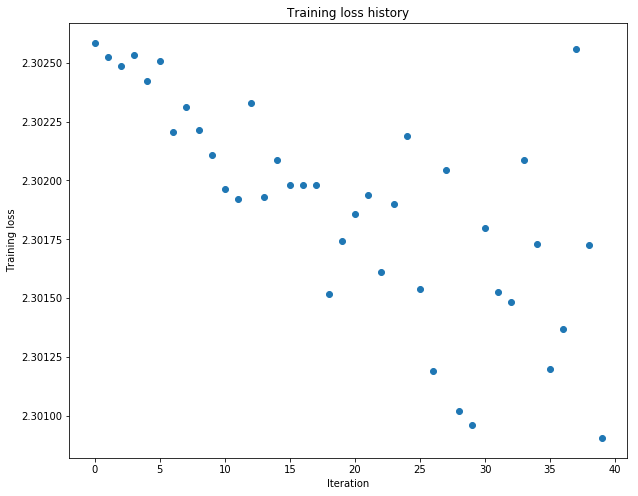

In [27]:
# ЗАДАНИЕ: используйте пятислойную сеть, чтобы получить переобучение на
# 50 обучающих примерах при соответствующем выборе
# скорости обучения и масштаба инициализации.
def run_model(weight_scale,learning_rate):
    model = FullyConnectedNet([100, 100,100,100],
            weight_scale=weight_scale, dtype=np.float64)
    solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                    'learning_rate': learning_rate,
                    }
             )
    solver.train()
    return solver.train_acc_history

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

not_reach = True
while not_reach:
    weight_scale = 10**(np.random.uniform(-6,-1))
    learning_rate = 10**(np.random.uniform(-4,-1))
    train_acc_hist = run_model(weight_scale,learning_rate)
    if max(train_acc_hist) == 1.0:
        not_reach = False
        lr = learning_rate
        ws = weight_scale

print('Has worked with %f and %f'%(lr,ws))
plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Вопрос  2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

Вы заметили какие-либо отличия обучения трехслойной сети по сравнению с обучением пятислойной сети? В частности, исходя из вашего опыта, какая сеть более чувствительна к масштабам инициализации? Как Вы думаете, почему?

## Ответ:
Значительно более тяжело обучать пятислойную сеть, нежели трехслойную


# Правила обновления
До сих пор мы использовали SGD для обновления араметров. Более сложные правила обновления могут облегчить обучение глубоких сетей. Реализуем несколько наиболее часто используемых правил обновления и сравним их с простым SGD.


# SGD+моменты
Стохастический градиентный спуск с моментом является широко используемым правилом обновления, которое ускоряет схождение глубоких сетей. Дополнительную информацию см. в разделе Momentum Update по адресу http://cs231n.github.io/neural-networks-3/#sgd.

Откройте файл `cs231n/optim.py` и прочитайте документацию в верхней части файла, чтобы убедиться, что вы понимаете API. Реализуйте правило обновления  SGD + момент в функции `sgd_momentum`и выполните код ниже, чтобы проверить вашу реализацию. Вы должны получить
ошибки меньше, чем e-8.

In [30]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Относительные ошибки должны быть около  e-8 или менее
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Теперь выполните код ниже, чтобы обучить шестислойную сеть с  SGD и  с SGD + момент. Вы должны увидеть, что правило обновления SGD + момент обеспечивает более быстрое схождение.

running with  sgd
(Iteration 1 / 200) loss: 2.968259
(Epoch 0 / 5) train acc: 0.129000; val_acc: 0.114000
(Iteration 11 / 200) loss: 2.184921
(Iteration 21 / 200) loss: 2.015097
(Iteration 31 / 200) loss: 1.858825
(Epoch 1 / 5) train acc: 0.283000; val_acc: 0.223000
(Iteration 41 / 200) loss: 1.947166
(Iteration 51 / 200) loss: 1.960709
(Iteration 61 / 200) loss: 1.795123
(Iteration 71 / 200) loss: 1.867337
(Epoch 2 / 5) train acc: 0.330000; val_acc: 0.278000
(Iteration 81 / 200) loss: 1.905438
(Iteration 91 / 200) loss: 1.591993
(Iteration 101 / 200) loss: 1.842909
(Iteration 111 / 200) loss: 1.628772
(Epoch 3 / 5) train acc: 0.392000; val_acc: 0.301000
(Iteration 121 / 200) loss: 1.797944
(Iteration 131 / 200) loss: 1.730168
(Iteration 141 / 200) loss: 1.602111
(Iteration 151 / 200) loss: 1.692223
(Epoch 4 / 5) train acc: 0.444000; val_acc: 0.320000
(Iteration 161 / 200) loss: 1.626771
(Iteration 171 / 200) loss: 1.647835
(Iteration 181 / 200) loss: 1.467199
(Iteration 191 / 200) los

e:\apps\python\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


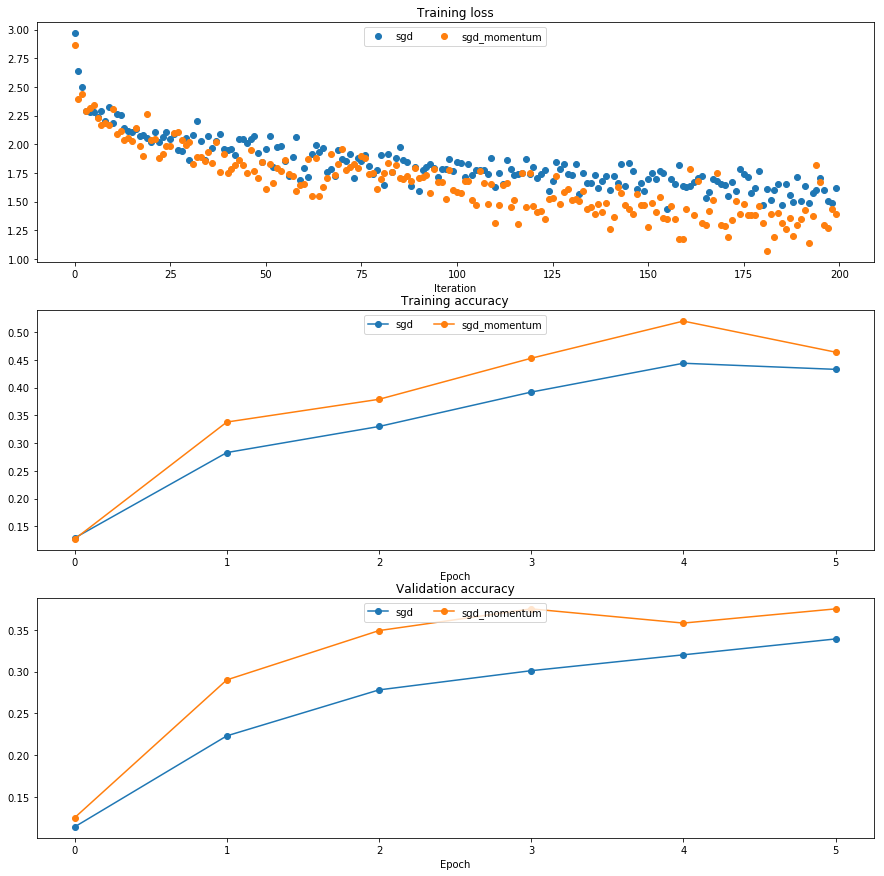

In [31]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp и Adam
RMSProp [1] и Adam [2] - это правила обновления, которые адаптируют скорости обучения для каждого параметра, используя среднее значение вторых моментов градиентов.

В файле `cs231n / optim.py`, реализуйте правило обновления RMSProp в функции` rmsprop` и реализуйте правило обновления Adam в функции `adam` и проверьте свои реализации, используя приведенные ниже тесты.

**ПРИМЕЧАНИЕ:** реализуйте  правило обновления _complete_ Adam (с механизмом коррекции смещения), а не упрощенную версию.


[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [32]:
# Тест для  RMSProp
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# Относительные ошибки должны быть около  e-7 или менее
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [33]:
# Тест для  Adam
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# Относительные ошибки должны быть около  e-7 или менее
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.139887467333134e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


После того как вы отладите реализации RMSProp и Adam, запустите код ниже, чтобы обучить пару глубоких сетей, используя эти новые правила обновления:

running with  adam
(Iteration 1 / 200) loss: 2.489786
(Epoch 0 / 5) train acc: 0.161000; val_acc: 0.144000
(Iteration 11 / 200) loss: 2.080060
(Iteration 21 / 200) loss: 1.872564
(Iteration 31 / 200) loss: 1.782276
(Epoch 1 / 5) train acc: 0.388000; val_acc: 0.354000
(Iteration 41 / 200) loss: 1.680420
(Iteration 51 / 200) loss: 1.481405
(Iteration 61 / 200) loss: 1.630338
(Iteration 71 / 200) loss: 1.600521
(Epoch 2 / 5) train acc: 0.426000; val_acc: 0.346000
(Iteration 81 / 200) loss: 1.708927
(Iteration 91 / 200) loss: 1.593728
(Iteration 101 / 200) loss: 1.576915
(Iteration 111 / 200) loss: 1.454210
(Epoch 3 / 5) train acc: 0.510000; val_acc: 0.367000
(Iteration 121 / 200) loss: 1.446604
(Iteration 131 / 200) loss: 1.497957
(Iteration 141 / 200) loss: 1.500147
(Iteration 151 / 200) loss: 1.208831
(Epoch 4 / 5) train acc: 0.522000; val_acc: 0.371000
(Iteration 161 / 200) loss: 1.272329
(Iteration 171 / 200) loss: 1.257399
(Iteration 181 / 200) loss: 1.319509
(Iteration 191 / 200) lo

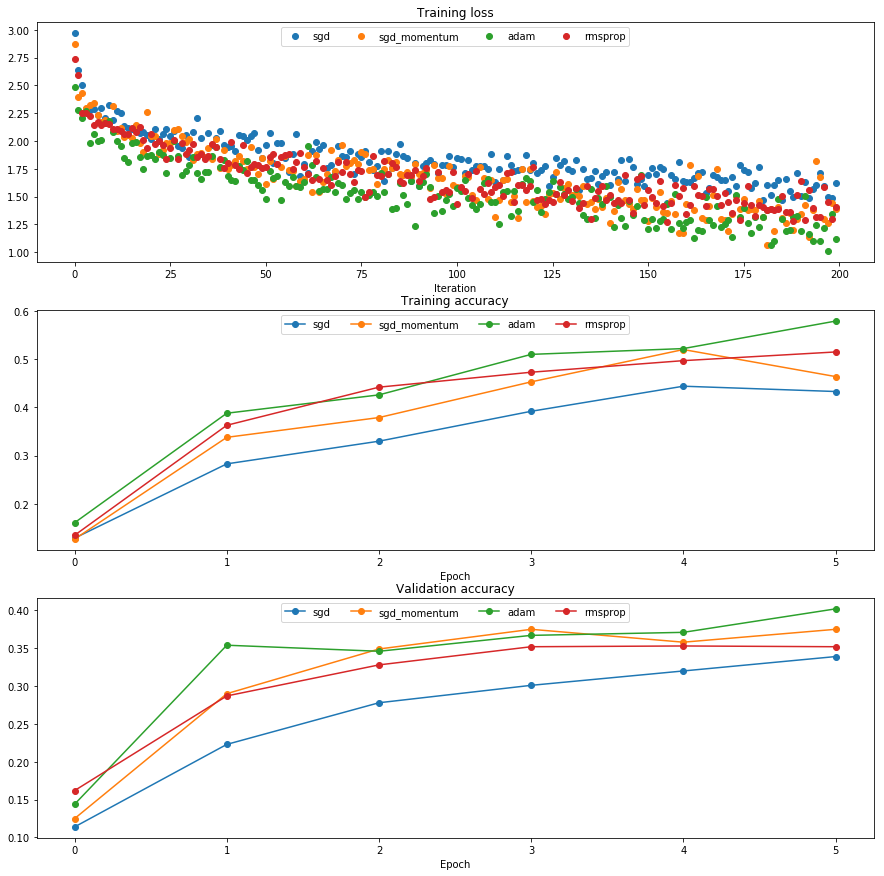

In [34]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Вопрос 3:
AdaGrad, подобно Адаму, является методом оптимизации для каждого параметра, который использует следующее правило обновления:

`` `
cache + = dw ** 2
w + = - learning_rate * dw / (np.sqrt (cache) + eps)
`` `

Замечено, что, когда сеть обучается с AdaGrad, обновления могут стать очень маленькими, и сеь начинает сеть обучакться медленно. Почему, по вашему мнению, обновления становятся очень маленькими? У Adam  есть такая проблема?


## Ответ:
Недостаток Adagrad в том, что cache может увеличиваться сколько угодно, что через некоторое время приводит к слишком маленьким обновлениям и параличу алгоритма. RMSProp и Adadelta призваны исправить этот недостаток.

## Постройте  хорошую модель!
Получите путем обучения на базе CIFAR-10 наилучшую полносвязанную модель на базе,  сохраняя лучшую модель в переменной best_model. Вы должны получить точность не хуже 50% на валидационном множестве.

Если вы будете внимательны, то должны  получить точность выше 55%, но мы не требуем этого в этой части задания. Позже Вы обучите сверточную сеть и мы предпочли бы, чтобы вы тратили свои усилия на сверточные сети.

Вам будет полезно заполнить блокноты BatchNormalization.ipynb и Dropout.ipynb, прежде чем завершить эту часть, поскольку эти методы помогут вам получить более эффективные модели.

(Iteration 1 / 19600) loss: 3.320277
(Epoch 0 / 10) train acc: 0.115000; val_acc: 0.104000
(Iteration 101 / 19600) loss: 2.669475
(Iteration 201 / 19600) loss: 2.419891
(Iteration 301 / 19600) loss: 2.021200
(Iteration 401 / 19600) loss: 1.999677
(Iteration 501 / 19600) loss: 1.918821
(Iteration 601 / 19600) loss: 2.145667
(Iteration 701 / 19600) loss: 2.133782
(Iteration 801 / 19600) loss: 1.930480
(Iteration 901 / 19600) loss: 2.126941
(Iteration 1001 / 19600) loss: 1.495509
(Iteration 1101 / 19600) loss: 1.737264
(Iteration 1201 / 19600) loss: 1.780493
(Iteration 1301 / 19600) loss: 1.534262
(Iteration 1401 / 19600) loss: 1.837931
(Iteration 1501 / 19600) loss: 1.907484
(Iteration 1601 / 19600) loss: 1.841887
(Iteration 1701 / 19600) loss: 1.720661
(Iteration 1801 / 19600) loss: 1.963660
(Iteration 1901 / 19600) loss: 1.626616
(Epoch 1 / 10) train acc: 0.424000; val_acc: 0.445000
(Iteration 2001 / 19600) loss: 2.187938
(Iteration 2101 / 19600) loss: 1.904731
(Iteration 2201 / 19600)

(Iteration 19001 / 19600) loss: 1.231307
(Iteration 19101 / 19600) loss: 0.976164
(Iteration 19201 / 19600) loss: 1.092766
(Iteration 19301 / 19600) loss: 1.227545
(Iteration 19401 / 19600) loss: 1.176207
(Iteration 19501 / 19600) loss: 1.108284
(Epoch 10 / 10) train acc: 0.576000; val_acc: 0.537000


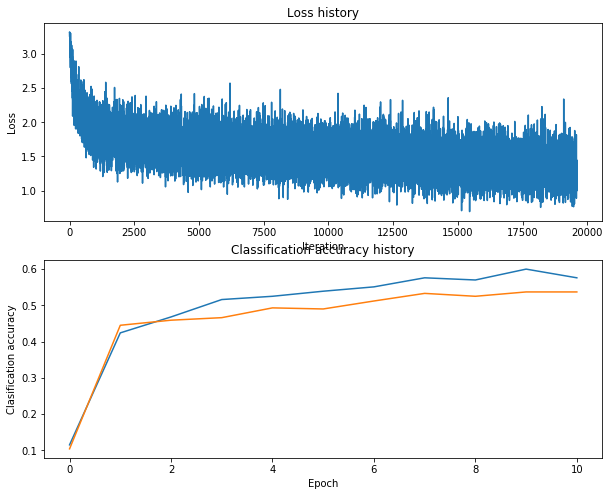

In [37]:
best_model = None
################################################################################
# ЗАДАНИЕ: Получите лучшую FullyConnectedNet на мно-ве CIFAR-10. Можно         #
# использовать нормализацию на блоке/слое и dropout. Сохраните свою лучшую     #
# модель в переменной  best_model.                                             #
################################################################################
X_val= data['X_val']
y_val= data['y_val']
X_test= data['X_test']
y_test= data['y_test']

lr = 3.113669e-04 #[10] #[2.379994e-04] # 10**np.random.uniform(-7,1,20)
ws = 2.461858e-02

model = FullyConnectedNet([100, 100, 100, 100],
      weight_scale=ws, dtype=np.float64,normalization=None, reg= 1e-2)
solver = Solver(model, data,
        print_every=100, num_epochs=10, batch_size=25,
        update_rule='adam',
        optim_config={
          'learning_rate': lr,
        },
        lr_decay = 0.9,
        verbose = True
        )   

solver.train()

plt.subplot(2, 1, 1)
plt.plot(solver.loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, label='train')
plt.plot(solver.val_acc_history, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show() 


best_model = model
################################################################################
#                              КОНЕЦ ВАШЕГО  КОДА                              #
################################################################################

# Проверьте свою модель!
Запустите свою лучшую модель на валидационном и тестовом множествах. Вы должны получить точность выше 50% точности на валидационно мможестве.

In [38]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.537
Test set accuracy:  0.513
